## Calibrate magnitude offset to reflect spoiler or imposter star partly in search box

If a spoiler or imposter star is within 4 pixels of the effective search box edge, then
some pixels are outside the search box and the spoiler is effectively fainter.

This notebook computes a positive magnitude offset to reflect the fraction of the star /
imposter light that is actually within the box. This offset is empirically determined
from the ACA star PSF.

In reality the PEA does not work exactly like that, and imposters (hot pixels) do not
necessarily have a star-like PSF. This ad hoc method is mostly a handy and performant
way to ensure that small changes in T_ccd result in small changes in the probabibility
that a candidate acquisition star is the brightest in the search box.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from chandra_aca.aca_image import AcaPsfLibrary
from chandra_aca.transform import count_rate_to_mag, mag_to_count_rate

matplotlib.style.use("bmh")
%matplotlib inline

psf_lib = AcaPsfLibrary()

In [2]:
def get_dmags(offsets=None, mag0=10.0):
    if offsets is None:
        offsets = np.arange(-4, 4.01, 0.01)
    norm = mag_to_count_rate(mag0)
    dmags = {"row": [], "col": []}
    for axis in "row", "col":
        for offset in offsets:
            rc = (offset, 0) if axis == "row" else (0, offset)
            img = psf_lib.get_psf_image(*rc, pix_zero_loc="edge", norm=norm)
            img_clip = img.aca[:0, :] if axis == "row" else img.aca[:, :0]
            norm_clip = float(np.sum(img_clip))
            mag_clip = count_rate_to_mag(norm_clip) if norm_clip > 0 else mag0 + 10
            dmags[axis].append(mag_clip - mag0)
    dmags["mean"] = np.mean([dmags["row"], dmags["col"]], axis=0)
    return offsets, dmags

In [3]:
offsets_int, dmags_int = get_dmags(offsets=[-4, -2.0, -1.0, 0, 1, 2.5, 3.4, 4])

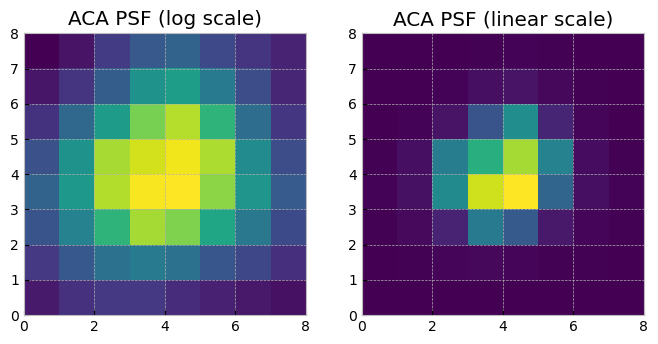

In [4]:
img = psf_lib.get_psf_image(0, 0, pix_zero_loc="edge", norm=10000)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(np.log10(img), origin="lower", extent=(0, 8, 0, 8))
axes[0].set_title("ACA PSF (log scale)")
axes[1].imshow(img, origin="lower", extent=(0, 8, 0, 8))
axes[1].set_title("ACA PSF (linear scale)");

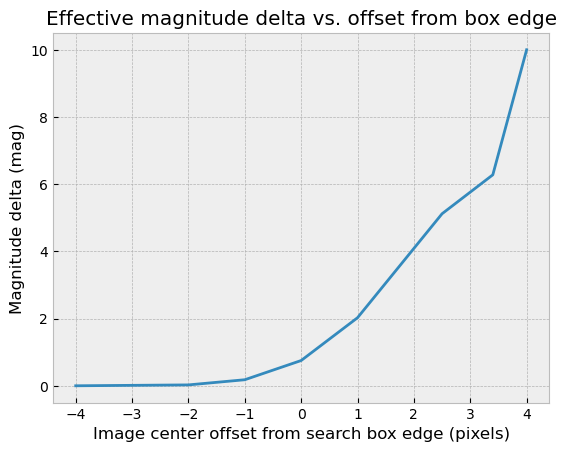

In [5]:
plt.plot(offsets_int, dmags_int["mean"])
plt.xlabel("Image center offset from search box edge (pixels)")
plt.title("Effective magnitude delta vs. offset from box edge")
plt.ylabel("Magnitude delta (mag)");

In [6]:
print(np.array(offsets_int) * 5)
print([np.round(x, 2) for x in dmags_int["mean"]])

[-20.  -10.   -5.    0.    5.   12.5  17.   20. ]
[0.0, 0.03, 0.18, 0.75, 2.03, 5.12, 6.28, 10.0]
